# Import the libraries necessary for data processing, visualization and model training

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# ML libraries for quick processing

from sklearn.preprocessing import MinMaxScaler
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import lightgbm as lgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthcare-claims-prediction/sample_submission.csv
/kaggle/input/healthcare-claims-prediction/patient_data_test.json
/kaggle/input/healthcare-claims-prediction/train.csv
/kaggle/input/healthcare-claims-prediction/patient_data_train.json


# Read the training data files

In [3]:
# Load the data --
train_data = pd.read_csv("/kaggle/input/healthcare-claims-prediction/train.csv")
patient_train_data = pd.read_json("/kaggle/input/healthcare-claims-prediction/patient_data_train.json")
patient_test_data = pd.read_json("/kaggle/input/healthcare-claims-prediction/patient_data_test.json")
sample_submission_data= pd.read_csv("/kaggle/input/healthcare-claims-prediction/sample_submission.csv")

In [4]:
train_data.head()

,PatientID,TotalClaims
0,100041,28424
1,100179,22212
2,100210,44841
3,100794,16506
4,101629,25796


In [5]:
patient_train_data.head()

,PatientID,Sex,Age,Conditions,Out patient costs
0,100041,M,79,"{'HD': 4, 'HT': 2}","{'2023': 17312, '2022': 16769, '2021': 16226, ..."
1,100179,F,71,"{'DB': 1, 'HD': 1, 'HT': 1}","{'2023': 14028, '2022': 12292, '2021': 10557, ..."
2,100210,F,84,"{'AT': 2, 'DB': 4, 'HD': 4, 'HT': 1}","{'2023': 24653, '2022': 30431, '2021': 31393, ..."
3,100794,M,67,"{'DB': 3, 'HD': 1}",{'2023': 5113}
4,101629,M,72,"{'DB': 1, 'HD': 2, 'HT': 1}","{'2023': 15652, '2022': 14150, '2021': 12376, ..."


In [6]:
patient_train_data.head()

,PatientID,Sex,Age,Conditions,Out patient costs
0,100041,M,79,"{'HD': 4, 'HT': 2}","{'2023': 17312, '2022': 16769, '2021': 16226, ..."
1,100179,F,71,"{'DB': 1, 'HD': 1, 'HT': 1}","{'2023': 14028, '2022': 12292, '2021': 10557, ..."
2,100210,F,84,"{'AT': 2, 'DB': 4, 'HD': 4, 'HT': 1}","{'2023': 24653, '2022': 30431, '2021': 31393, ..."
3,100794,M,67,"{'DB': 3, 'HD': 1}",{'2023': 5113}
4,101629,M,72,"{'DB': 1, 'HD': 2, 'HT': 1}","{'2023': 15652, '2022': 14150, '2021': 12376, ..."


In [7]:
patient_test_data.head()

,PatientID,Sex,Age,Conditions,Out patient costs
0,7053446,F,69,"{'AT': 2, 'DB': 2, 'HD': 5, 'HT': 2}","{'2023': 15035, '2022': 13054, '2021': 11076}"
1,7054536,M,70,"{'DB': 4, 'HT': 2}","{'2023': 6075, '2022': 5306, '2021': 4603, '20..."
2,7055023,F,71,"{'AT': 2, 'HD': 2, 'HT': 1}","{'2023': 14094, '2022': 12349, '2021': 10605, ..."
3,7055403,M,75,"{'AT': 1, 'HD': 4}","{'2023': 16496, '2022': 15318, '2021': 14140, ..."
4,7055459,M,73,"{'DB': 2, 'HT': 1}","{'2023': 8109, '2022': 7415, '2021': 6721, '20..."


# Transform the JSON data and normalize it for better training

The columns conditions and Out Patients costs has the dictionary data, which we need to normalize to categorize and better understand the data.

Below function normalize the conditions and Out Patient costs in the data set so we have more structured and tabular data

In [8]:
# Function to modify the base dataframe and return a cleansed dataframe

def updated_df(df):
    # Change the json to columns to better format the data 
    conditions_df = pd.json_normalize(df['Conditions'])
    conditions_df.fillna(0, inplace=True)
    conditions_df=conditions_df.astype(int)
    #df = pd.concat([df,conditions_df], axis =1)
    # Normalize the costs 
    
    costs_df = pd.json_normalize(df['Out patient costs'])
    costs_df.fillna(0,inplace=True)
    
    #Concat all the normalized dataframes.  
    df = pd.concat([df,conditions_df,costs_df],axis =1)
    
    
    # Convert Sex to binary values
    df['Sex'] = df['Sex'].map({'M':1,"F":0})
    
    # Standardize the ages to get the minMax  scaler values
    
    scaler = MinMaxScaler()
    df['scaled_age']= scaler.fit_transform(df[['Age']])
    
    # Now identify the columns of interest and just keep those. 
    
    col_list = ['Conditions','Out patient costs','Age']
    
    df.drop(columns = col_list,inplace=True)
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    
    # Get the count of preconditions an individual have to understand the how preconditions in group affect the claims amount
    df['PreconditionCount'] = (df[['HT','HD','DB','AT']]>0).sum(axis=1)
    df['Critical_preconditions'] = (df[['HT','HD','DB','AT']]>3).sum(axis=1)>1
    
    return df
    
    

# Modify the data files

In [9]:
# Now Change the dataframes for patient_train and patient_test

patient_train_data = updated_df(patient_train_data)

patient_test_data = updated_df(patient_test_data)


In [10]:
patient_train_data.head()

,PatientID,Sex,HD,HT,DB,AT,2023,2022,2021,2020,2019,scaled_age,PreconditionCount,Critical_preconditions
0,100041,1,4,2,0,0,17312.0,16769.0,16226.0,15522.0,14819.0,0.722222,2,False
1,100179,0,1,1,1,0,14028.0,12292.0,10557.0,8936.0,7316.0,0.277778,3,False
2,100210,0,4,1,4,2,24653.0,30431.0,31393.0,32357.0,32206.0,1.000000,4,True
3,100794,1,1,0,3,0,5113.0,0.0,0.0,0.0,0.0,0.055556,2,False
4,101629,1,2,1,1,0,15652.0,14150.0,12376.0,10602.0,8982.0,0.333333,3,False


In [11]:
patient_test_data.head()

,PatientID,Sex,AT,DB,HD,HT,2023,2022,2021,2020,2019,scaled_age,PreconditionCount,Critical_preconditions
0,7053446,0,2,2,5,2,15035.0,13054.0,11076.0,0.0,0.0,0.166667,4,False
1,7054536,1,0,4,0,2,6075.0,5306.0,4603.0,3900.0,0.0,0.222222,2,False
2,7055023,0,2,0,2,1,14094.0,12349.0,10605.0,8975.0,7347.0,0.277778,3,False
3,7055403,1,1,0,4,0,16496.0,15318.0,14140.0,12956.0,11771.0,0.500000,2,False
4,7055459,1,0,2,0,1,8109.0,7415.0,6721.0,5902.0,5082.0,0.388889,2,False


# Merge Patient and Claims data on Patient ID . 

Given both the data set have the same number of records and inner join does not let us loose on any records we go with inner join data else we would have preferred the outer join

In [12]:
merged_patient_train_data = pd.merge(patient_train_data,train_data,how = "inner", left_on='PatientID', right_on = 'PatientID', suffixes = ('patient_train','_train'))
merged_patient_train_data.head()

,PatientID,Sex,HD,HT,DB,AT,2023,2022,2021,2020,2019,scaled_age,PreconditionCount,Critical_preconditions,TotalClaims
0,100041,1,4,2,0,0,17312.0,16769.0,16226.0,15522.0,14819.0,0.722222,2,False,28424
1,100179,0,1,1,1,0,14028.0,12292.0,10557.0,8936.0,7316.0,0.277778,3,False,22212
2,100210,0,4,1,4,2,24653.0,30431.0,31393.0,32357.0,32206.0,1.000000,4,True,44841
3,100794,1,1,0,3,0,5113.0,0.0,0.0,0.0,0.0,0.055556,2,False,16506
4,101629,1,2,1,1,0,15652.0,14150.0,12376.0,10602.0,8982.0,0.333333,3,False,25796


# Exploratory Data Analysis

# # Understand Correlation between Age, Total Claim and each year claims

1. As we notice that the age has equal distirbution of data, showing signs age has equal representation of data. 
2. All the age group shows similar claims count, people on the higher age bracket shows the claim amount to be of higher value. Which shows there could be a realtion between the age and the claims amount.
3. Every passing year we have claims amount rising and the number of claims filed by indidividuals more than previous year in general sense. Now this could be due to a) these are new enrollments or they haven't made any claims b) claims have risen due to inflation or any other external factors
4. Each passing year we notice that the claims amount shows a linear corelation with the previous year claims and have claims of higher amount against previous year.Also claims shows normal distribution.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

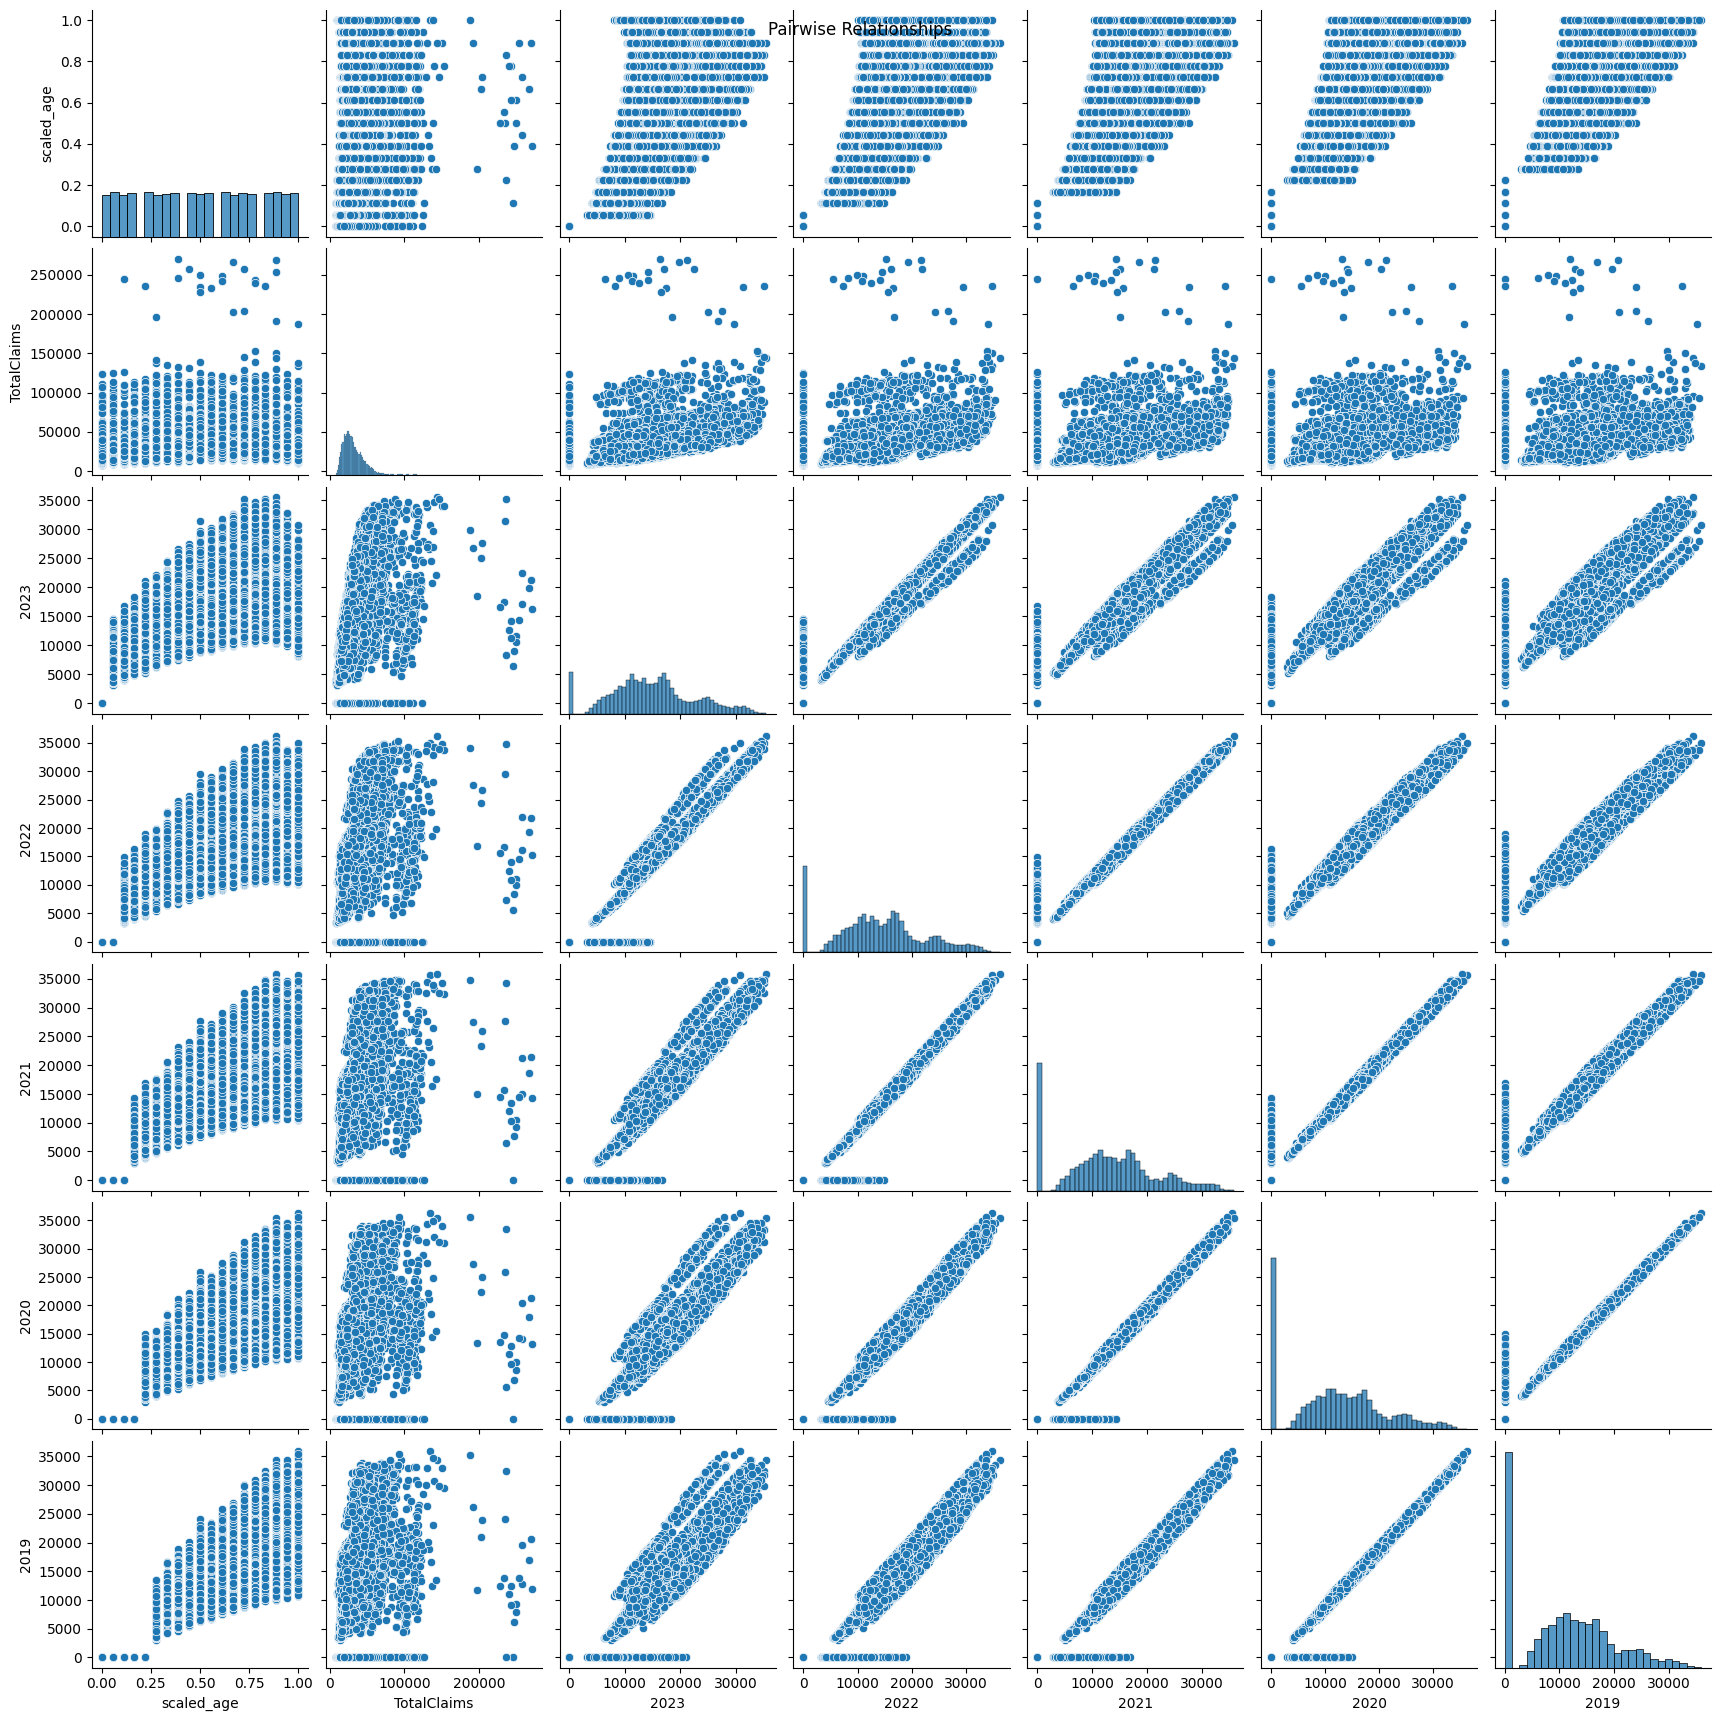

In [13]:

sns.pairplot(merged_patient_train_data[['scaled_age', 'TotalClaims', '2023', '2022', '2021', '2020', '2019']])
plt.suptitle('Pairwise Relationships')
plt.show()


# # Corelation Matrix -

Identify which attributes are highly correlated and understan if they contribute to the claims amount. 

1. Critical Condition, Precondition and Previous year claims shows a high correlation with the claims amount. 

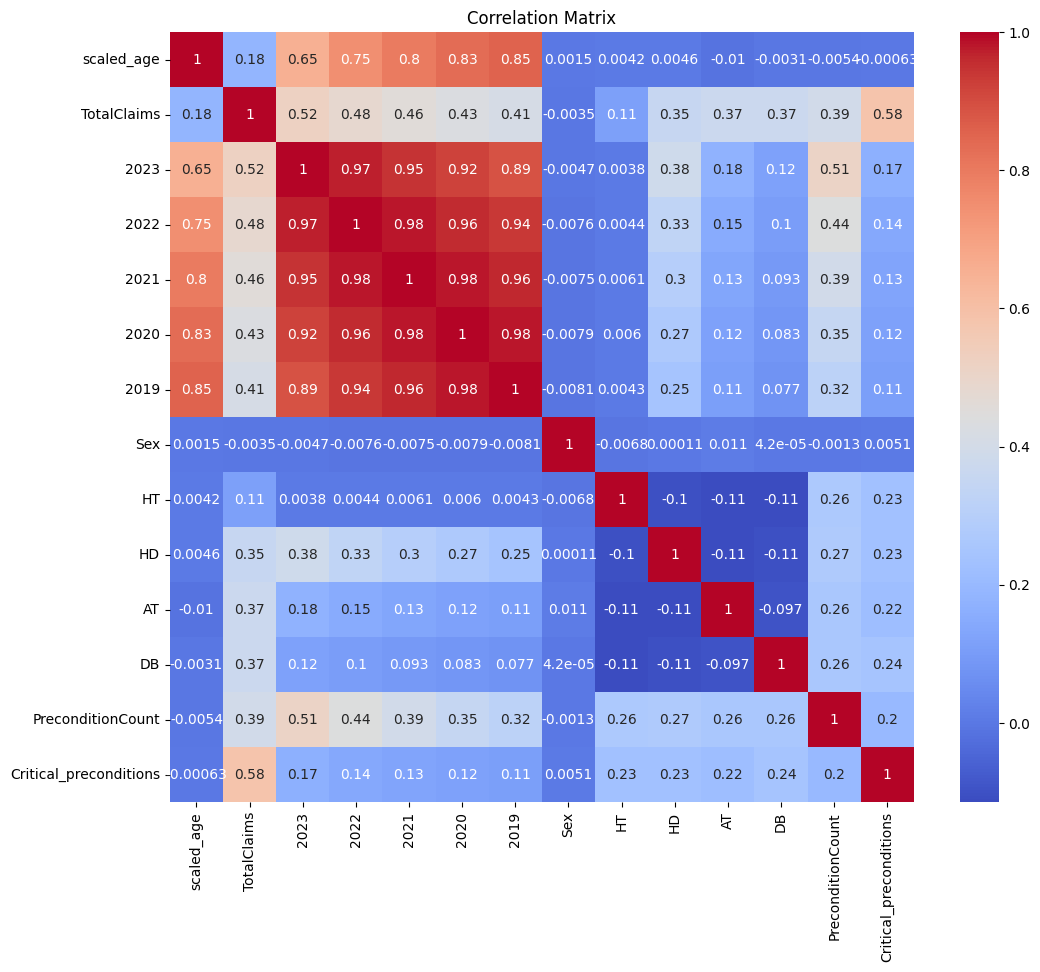

In [14]:
correlation_matrix = merged_patient_train_data[['scaled_age', 'TotalClaims', '2023', '2022', '2021', '2020', '2019','Sex', 'HT','HD','AT','DB','PreconditionCount','Critical_preconditions']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Understand the Mean Claims Amount based on the Precondition and the category of the condition.

We can clearly notice that the mean claims amounts is higher when the category of claims is 4 or higher.
Also to notice that the claim amounts has been higher for precondition of AT and DB with category as 4 or higher. 

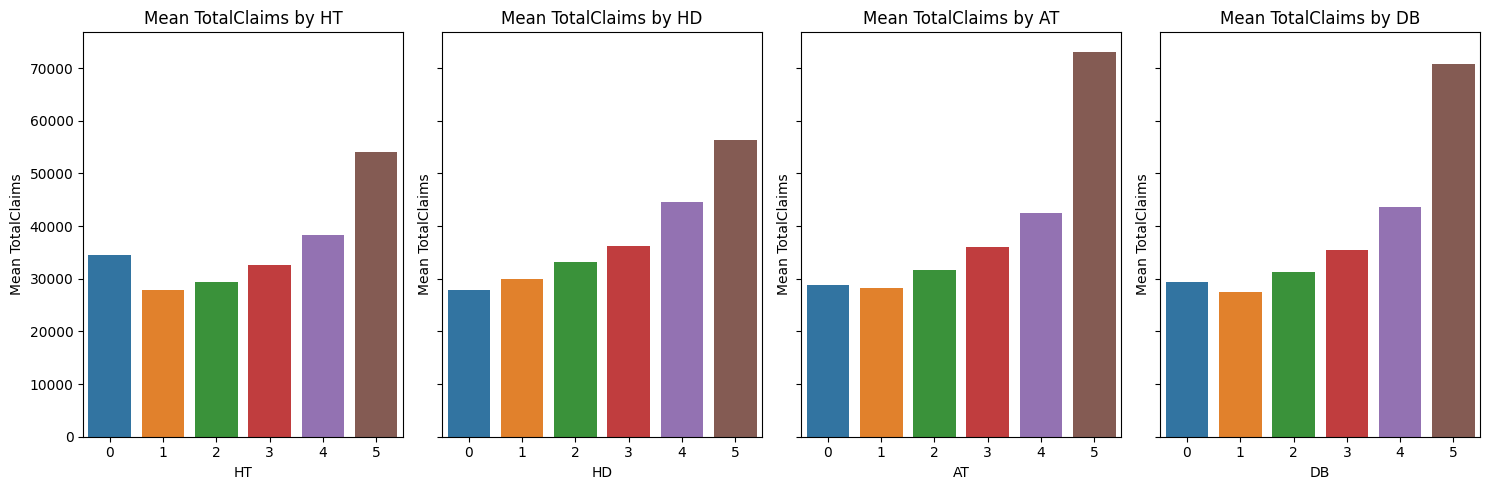

In [15]:
# Let's plot the mean claims amount based on the disease and its grade 


def plot_mean_total_claims_by_condition(data, columns, figsize=(15, 5)):
    """
    Plots the mean TotalClaims for each value in the specified columns.
    
    Parameters:
    - data: DataFrame containing the data.
    - columns: List of column names to plot.
    - figsize: Tuple specifying the size of the figure.
    """
    # Set up the matplotlib figure
    num_plots = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=figsize, sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for ax, col in zip(axes, columns):
        # Calculate mean TotalClaims for each unique value in the column
        mean_claims = data.groupby(col)['TotalClaims'].mean().reset_index()
        
        # Plot
        sns.barplot(x=col, y='TotalClaims', data=mean_claims, ax=ax)
        ax.set_title(f'Mean TotalClaims by {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Mean TotalClaims')
    
    plt.tight_layout()
    plt.show()

# Example usage
columns_to_plot = ['HT', 'HD', 'AT', 'DB']
plot_mean_total_claims_by_condition(merged_patient_train_data, columns_to_plot)


# Observe mean claim amounts based on number of precondition diseases

Claims amount go higher and higher as the number of preconditions increase and the mean claims amount goes to the tune of around $48000
Also a point to note is that the almost all the patients has atleast 2 precondition to 4 preconditions

Text(0, 0.5, 'Mean TotalClaims')

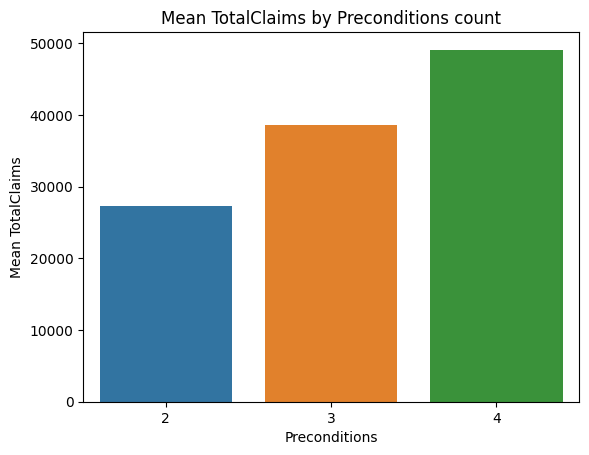

In [16]:
# PLot the trends for mean total claims based on precondition count
mean_claims = merged_patient_train_data.groupby('PreconditionCount')['TotalClaims'].mean().reset_index()
        
# Plot
sns.barplot(x='PreconditionCount', y='TotalClaims', data=mean_claims)
plt.title(f'Mean TotalClaims by Preconditions count')
plt.xlabel('Preconditions')
plt.ylabel('Mean TotalClaims')

## Mean Claims Amount based on Critical Preconditions of level 4 for atleast two or more. 

AS we notice we have a stark difference in the claims amount of with people having more than 1 preconditions of level 4 and above.
Certainly it could be a reason as which mimics the real life.

Text(0, 0.5, 'Mean TotalClaims')

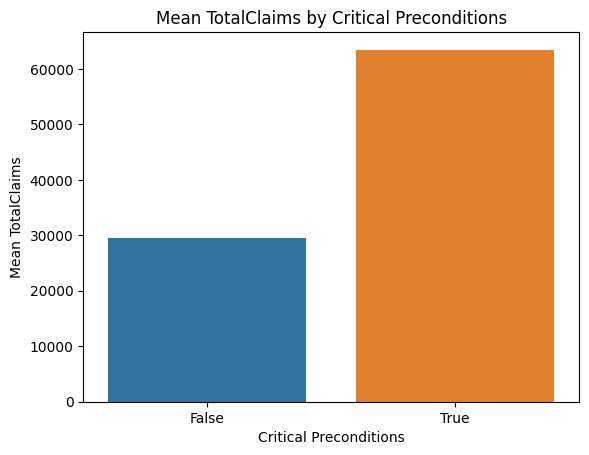

In [17]:
# PLot the trends for mean total claims based on precondition count
mean_claims = merged_patient_train_data.groupby('Critical_preconditions')['TotalClaims'].mean().reset_index()
        
# Plot
sns.barplot(x='Critical_preconditions', y='TotalClaims', data=mean_claims)
plt.title(f'Mean TotalClaims by Critical Preconditions')
plt.xlabel('Critical Preconditions')
plt.ylabel('Mean TotalClaims')

In [18]:
merged_patient_train_data.head()

,PatientID,Sex,HD,HT,DB,AT,2023,2022,2021,2020,2019,scaled_age,PreconditionCount,Critical_preconditions,TotalClaims
0,100041,1,4,2,0,0,17312.0,16769.0,16226.0,15522.0,14819.0,0.722222,2,False,28424
1,100179,0,1,1,1,0,14028.0,12292.0,10557.0,8936.0,7316.0,0.277778,3,False,22212
2,100210,0,4,1,4,2,24653.0,30431.0,31393.0,32357.0,32206.0,1.000000,4,True,44841
3,100794,1,1,0,3,0,5113.0,0.0,0.0,0.0,0.0,0.055556,2,False,16506
4,101629,1,2,1,1,0,15652.0,14150.0,12376.0,10602.0,8982.0,0.333333,3,False,25796


# Build the Base Model

Let's try to build the base model by treating the nuerical columns as standardScaler (normalizing the data ) and categorical columns as onehotEncoder adn then train the LGBM regressor with default parameters.

The RMSE we attained is - **3708.6181444276** which the tree evolved by improving its score from **33217.727933**

Let's do some feature engineering and hyper parameter tunning for the model to get the best features and then build the mode. 

In [19]:
# Drop non-feature columns
X = merged_patient_train_data.drop(columns=['PatientID', 'TotalClaims'])
y = merged_patient_train_data['TotalClaims']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features

numerical_features = ['scaled_age', 'HT', 'HD', 'DB', 'AT', '2023', '2022', '2021', '2020', '2019', 'PreconditionCount']
cat_features = ['Critical_preconditions']
# Create transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Create the pipeline with preprocessing and LGBM model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 11703, number of used features: 13
[LightGBM] [Info] Start training from score 33217.727933
Mean Squared Error: 13753848.541177616
Root Mean Squared Error: 3708.6181444276


# Create the Study to Run the LGBMRegressor to identify the best parameters.

We will create a study tot let us reduce the RMSE and get the minimum score by running an study of parameters.

In [ ]:
# import optuna
# import lightgbm as lgb
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     param = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 150),
#         'max_depth': trial.suggest_int('max_depth', -1, 30),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'verbose':-1,
#         'force_col_wise':True
#     }
#     numerical_features = ['scaled_age', 'HT', 'HD', 'DB', 'AT', '2023', '2022', '2021', '2020', '2019', 'PreconditionCount']
#     cat_features = ['Critical_preconditions']
#     # Create transformers for preprocessing
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', Pipeline(steps=[
#                 ('imputer', SimpleImputer(strategy='mean')),
#                 ('scaler', StandardScaler())
#             ]), numerical_features),
#             ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
#         ]
#     )
#     # Create the pipeline with preprocessing and LGBM model
#     model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', lgb.LGBMRegressor(**param, random_state=42))])
#     #score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
#     # K-Fold cross-validation
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     try:
#         score = -np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
#         return score**0.5  # Return RMSE
#     except Exception as e:
#         print(f"Error with params {param}: {e}")
#         return float('inf')  # Return a large value if there's an errorscore = -np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

# study = optuna.create_study(study_name='lgbm_parameters',direction='minimize')
# study.optimize(objective, n_trials=100,show_progress_bar=True)

# print("Best parameters:", study.best_params)
# print("Best RMSE:", study.best_value)

**Best Parameters post study are -**

{'learning_rate': 0.08186788972837733, 'num_leaves': 42, 'max_depth': -1, 'n_estimators': 853, 'min_child_samples': 23, 'subsample': 0.7350619610972876, 'colsample_bytree': 0.9992265462985974, 'reg_alpha': 0.8916379336006304, 'reg_lambda': 0.8227604315545862}

**Best RMSE: 3381.03760059753**

**Note:** Below Commented one section are the parameters which were iterative in nature and were outcome of the study before the feature engineering to furthere optimize the model .

In [ ]:
# # Create the model and train on full data for base and then create the 
# params1 = {'learning_rate': 0.03294489317076741, 
#           'num_leaves': 37, 
#           'max_depth': 8, 
#           'n_estimators': 897, 
#           'min_child_samples': 5, 
#           'subsample': 0.968708331789826, 
#           'colsample_bytree': 0.8706352702688643, 
#           'reg_alpha': 0.8686221296731311, 
#           'reg_lambda': 0.844235838004945
#          }
# param2 = {'learning_rate': 0.0516389958280087,
#           'num_leaves': 24,
#           'max_depth': 23,
#           'n_estimators': 334,
#           'min_child_samples': 5,
#           'subsample': 0.7600528857989037,
#           'colsample_bytree': 0.8923381208272642,
#           'reg_alpha': 0.7246449383527979,
#           'reg_lambda': 0.3563093860699633,
#           'force_col_wise':True
#          }

# param3 = {'learning_rate': 0.09849906067417588, 
#           'num_leaves': 20, 
#           'max_depth': 6, 
#           'n_estimators': 977, 
#           'min_child_samples': 27, 
#           'subsample': 0.5235759964034972, 
#           'colsample_bytree': 0.9731704516353431, 
#           'reg_alpha': 0.5479983486775312, 
#           'reg_lambda': 0.8958999115317866}

param4 = {'learning_rate': 0.08186788972837733,
          'num_leaves': 42,
          'max_depth': -1,
          'n_estimators': 853,
          'min_child_samples': 23,
          'subsample': 0.7350619610972876,
          'colsample_bytree': 0.9992265462985974,
          'reg_alpha': 0.8916379336006304,
          'reg_lambda': 0.8227604315545862}

Lets see some sample test data and set the index as patient ID.

In [20]:
patient_test_data.set_index('PatientID', inplace=True)
patient_test_data.head()

,Sex,AT,DB,HD,HT,2023,2022,2021,2020,2019,scaled_age,PreconditionCount,Critical_preconditions
PatientID,,,,,,,,,,,,,
7053446,0,2,2,5,2,15035.0,13054.0,11076.0,0.0,0.0,0.166667,4,False
7054536,1,0,4,0,2,6075.0,5306.0,4603.0,3900.0,0.0,0.222222,2,False
7055023,0,2,0,2,1,14094.0,12349.0,10605.0,8975.0,7347.0,0.277778,3,False
7055403,1,1,0,4,0,16496.0,15318.0,14140.0,12956.0,11771.0,0.500000,2,False
7055459,1,0,2,0,1,8109.0,7415.0,6721.0,5902.0,5082.0,0.388889,2,False


# Train the model on the best parameters and full data to see if the model changes its performance from RMSE of validation data set.

Get the predictions on the unseen data in the test file

In [ ]:

X = merged_patient_train_data.drop(columns=['PatientID', 'TotalClaims'])
y = merged_patient_train_data['TotalClaims']
numerical_features = ['scaled_age', 'HT', 'HD', 'DB', 'AT', '2023', '2022', '2021', '2020', '2019', 'PreconditionCount']
# Create transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ])

# Create the pipeline with preprocessing and LGBM model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(**param4))
])
# Train the model
model.fit(X, y)

# Make predictions
test_pred = model.predict(patient_test_data)
test_pred

# Genarete the submission data file. 

Generate the test submission file.

Post generation the 3rd iteration provided - a RMSE of **958.78** which is the best.

In [ ]:
submission_df = pd.DataFrame({'PatientID': patient_test_data.index,
             'TotalClaims':test_pred})
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False)

# Conclusion:
Our analysis shows that individuals with a higher number of pre-existing conditions at critical stages and advanced age tend to incur higher claim amounts. Using our predictive model, we achieved a **Root Mean Square Error (RMSE) of 957.78**, indicating that, on average, the predicted claim amounts are within approximately **$1,000** of the actual values.

However, this does not imply that every prediction will always be within a $1,000 range. Instead, it reflects the average closeness of our predictions. The error margin may vary depending on new data, especially if the new inputs differ significantly from the data the model was trained on.

**Next Steps -**

Further change the model to have the mean claims amount and the last year claims amount and the current year claims amount as for some people the previous year claims are 0 which means either they are newly enrolled or did not made claims. We will go with the assumption that they were not enrolled unless they have the value in the non-updated data. This would mean changes to the feature and the RMSE values calculated above. 

# Experiment Details 

**1. Experiment 1 - Get the claims predictions based on below parameters-**

{'learning_rate': 0.0516389958280087,
          'num_leaves': 24,
          'max_depth': 23,
          'n_estimators': 334,
          'min_child_samples': 5,
          'subsample': 0.7600528857989037,
          'colsample_bytree': 0.8923381208272642,
          'reg_alpha': 0.7246449383527979,
          'reg_lambda': 0.3563093860699633,
          'force_col_wise':True
         }
 Feature Engineering - 
 
 Have a column as preconditions count which captures if the patient has more than one preconditions . Often it has been observed that patients who have preconditions tends to have health concerns, which inherently impacts the claims amount. 
 We have validated this post hyper parameter tunning and noticed that it impacted the RMSE score and gave a decent RMSE score - **1102.067**

**2. Experiment 2 - Feature Engineering with adding a new paratmeter to understand if people have more than 1 preconditions and are in critical stage.**
As part of this exercise we will create a new parameter which captures critical preconditions as True or false if the patient has the level of 4 or above. 
The best parameters post training the data is - 
param3 = {'learning_rate': 0.09849906067417588, 
          'num_leaves': 20, 
          'max_depth': 6, 
          'n_estimators': 977, 
          'min_child_samples': 27, 
          'subsample': 0.5235759964034972, 
          'colsample_bytree': 0.9731704516353431, 
          'reg_alpha': 0.5479983486775312, 
          'reg_lambda': 0.8958999115317866}
          
The RMSE on the public score was - **1082.67**

Which is great improvement wrt to previous score. 

**3. Experiment 2 - Change the critical condition as a combination of more than 1 combined at level 4 and above.**

Combined critical preconditions of level 4 and above people have higher mean claims amount wrt to other people. This makes sense to include as part of the parameters. So we change the conditions of the critical preconditions to be True if more than 1 precondition are at level 4 and above. 

This lead to the new study with parameters of - 

param4 = {'learning_rate': 0.08186788972837733,
          'num_leaves': 42,
          'max_depth': -1,
          'n_estimators': 853,
          'min_child_samples': 23,
          'subsample': 0.7350619610972876,
          'colsample_bytree': 0.9992265462985974,
          'reg_alpha': 0.8916379336006304,
          'reg_lambda': 0.8227604315545862}

RMSE of the score is better than previous score and the updated RMSE is - **958.78**